## Hodge and Laplace operators consistency with least squares approach

In this notebook, we test the convergence of the Hodge star operator using a interpolation approach. The idea is to interpolate the differential forms over the edges of the mesh and then use the continuous Hodge star operator. The projection to the dual mesh is done by integrating the continuous linear differential forms over the edges of the dual mesh.

First, we must study the convergence of our interpolation operator. We built it to be exact for linear fields of the form
$$
v(x,y) = \begin{pmatrix} a_0 \\ a_1 \end{pmatrix} + \begin{pmatrix} a_2 & a_3 \\ a_4 & a_5 \end{pmatrix} \begin{pmatrix} x \\ y \end{pmatrix}
$$

If $t_e$ is the tangential vector of the edge $e$, we solve the system
$$
u_{e_i} = t_{e_i} \cdot v = \begin{pmatrix} t_{e_i,x} & t_{e_i,y} \end{pmatrix} \begin{pmatrix} a_0 \\ a_1 \end{pmatrix} + \begin{pmatrix} t_{e_i,x} & t_{e_i,y} \end{pmatrix} \begin{pmatrix} a_2 & a_3 \\ a_4 & a_5 \end{pmatrix} \begin{pmatrix} x \\ y \end{pmatrix} = \begin{pmatrix} t_{e_i,x} & t_{e_i,y} & t_{e_i,x}x & t_{e_i,x}y & t_{e_i,y}x & t_{e_i,y}y & \end{pmatrix} \begin{pmatrix} a_0 \\ a_1 \\ a_2 \\ a_3 \\ a_4 \\ a_5 \end{pmatrix},
$$
for $i=1,...,|C^1(K)|$. The solution is given by a least squares problem, which can be solved using the normal equations.


In [2]:
import numpy as np
from numpy import zeros, sort, loadtxt, array, pi, sin, cos, log, sqrt, sum
import matplotlib.pyplot as plt
from numpy.linalg import norm
from pydec import simplicial_complex
from pydec.mesh.simplex import simplex
from pydec.mesh.subdivision import loop_subdivision
from scipy.integrate import quad
from rec_vector_field_lsq import *

In [3]:
def integral_edge(F,p1,p2):
    r = lambda t: p2*t + (1-t)*p1
    dr = p2 - p1
    integrando = lambda t: F(r(t))@dr #pullback
    return quad(integrando, 0,1, epsabs=1e-13, epsrel=1e-13)[0]
def order(le, lh):
    p = [(log(le[i]/le[i+1]))/(log(lh[i]/lh[i+1])) for i in range(len(le)-1)]
    return p


In [4]:
vertices = loadtxt('../pydec/Examples/DarcyFlow/vertices_tm0.5.txt')
triangles = loadtxt('../pydec/Examples/DarcyFlow/triangles_tm0.5.txt', dtype='int') - 1
vertices, triangles = loop_subdivision(vertices, triangles)
vertices, triangles = loop_subdivision(vertices, triangles)
sc = simplicial_complex((vertices,triangles))
N0 = sc[0].num_simplices
N1 = sc[1].num_simplices

Solving for a particular edge and field.

In [5]:
form = lambda x: array([1 + 2*x[1] - x[0],-2 - 3*x[0] - 2*x[1]])
w = sc.get_cochain(1)
for i in range(N1):
    v0,v1 = vertices[sc[1].simplices[i]]
    w.v[i] = integral_edge(form, v0, v1)

edge_index = 41
p = sc[1].circumcenter[edge_index]
edges_to_triangles = create_edge_to_triangles(sc, triangles)
v,coefs = rec_vector_field_lsq(sc, w, edge_index, vertices, triangles, edges_to_triangles)
print('L2 error: ', norm(form(p) - v(p)))
print('coefs: ', coefs)

------Solving linear system-----
Residuals: [1.60429958e-31]
Rank: 6
condition number: 42.98468301935218
----------------------------------
L2 error:  3.4684476073050936e-15
coefs:  [ 1. -2. -1.  2. -3. -2.]


Solving for non-linear fields

In [6]:
form = lambda x: array([sin(pi*x[0])*cos(pi*x[1]), cos(pi*x[0])*sin(pi*x[1])])
w = sc.get_cochain(1)
for i in range(N1):
    v0,v1 = vertices[sc[1].simplices[i]]
    w.v[i] = integral_edge(form, v0, v1)

edge_index = 41
p = sc[1].circumcenter[edge_index]
edges_to_triangles = create_edge_to_triangles(sc, triangles)
v,coefs = rec_vector_field_lsq(sc, w, edge_index, vertices, triangles, edges_to_triangles)
print('L2 error: ', norm(form(p) - v(p)))
print('coefs: ', coefs)

------Solving linear system-----
Residuals: [1.53892928e-05]
Rank: 6
condition number: 42.98468301935222
----------------------------------
L2 error:  0.02494939223277098
coefs:  [ 0.5844061   0.66554042  0.81430715 -2.31140423 -2.28714794  0.655786  ]


Plotting the field and the interpolation

In [7]:
edge_to_triangles = create_edge_to_triangles(sc, triangles)
print(edge_to_triangles[41]) #gets the index of the triangle that contains the edge
print(sc[1].simplices[41]) #gets the vertices of the edge
triangles[edge_to_triangles[41]] #gets the triangles that contains the edge

[8, 132]
[10 96]


array([[ 10,  96, 128],
       [ 10, 111,  96]])

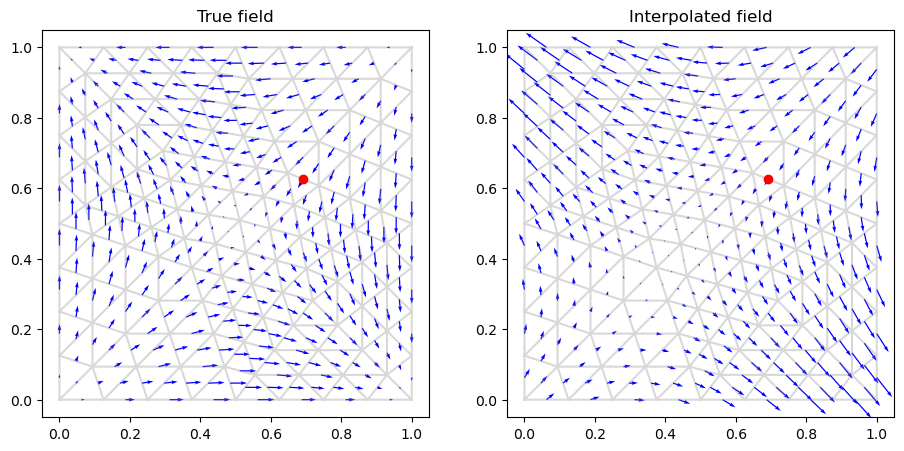

In [8]:
midpoints = sc[1].circumcenter
true_field = array([form(p) for p in midpoints])
interpolated_field = array([v(p) for p in midpoints])
fig, ax = plt.subplots(1,2, figsize=(11,6))
ax[0].quiver(midpoints[:,0], midpoints[:,1], true_field[:,0], true_field[:,1], color='blue')
ax[0].set_title('True field')
ax[0].set_aspect('equal')
ax[0].triplot(vertices[:,0], vertices[:,1], triangles, alpha=0.3, color='gray')
ax[0].plot(p[0], p[1], 'ro')
ax[1].quiver(midpoints[:,0], midpoints[:,1], interpolated_field[:,0], interpolated_field[:,1], color='blue')
ax[1].set_title('Interpolated field')
ax[1].set_aspect('equal')
ax[1].triplot(vertices[:,0], vertices[:,1], triangles, alpha=0.3, color='gray')
ax[1].plot(p[0], p[1], 'ro')
plt.show()

In [9]:
def l2_error(u,v):
    return sqrt(sum((u-v)**2))



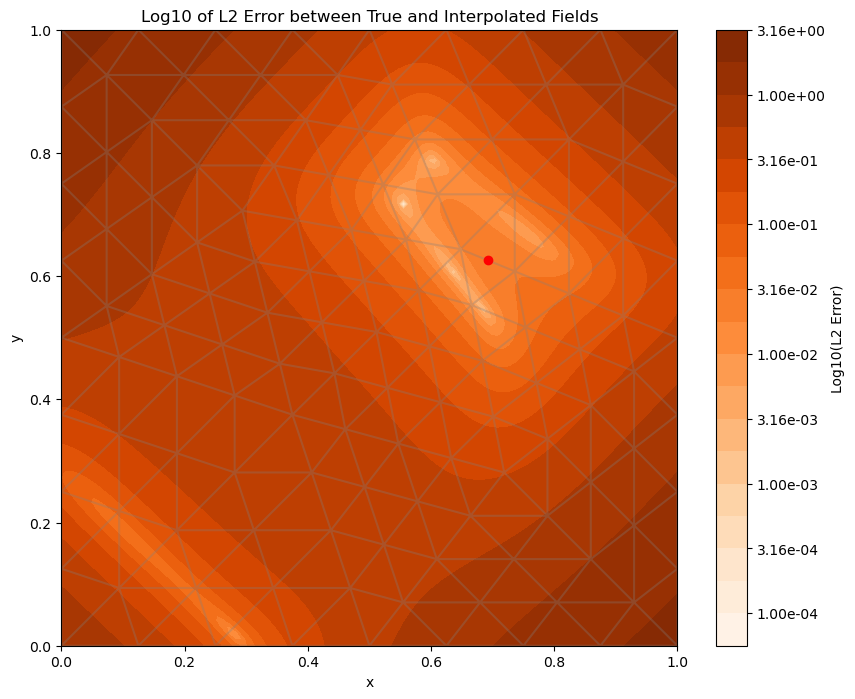

In [10]:
# Create a grid of points covering the domain
x_min, x_max = vertices[:,0].min(), vertices[:,0].max()
y_min, y_max = vertices[:,1].min(), vertices[:,1].max()
n_points = 100  # Number of points in each direction
x = np.linspace(x_min, x_max, n_points)
y = np.linspace(y_min, y_max, n_points)
X, Y = np.meshgrid(x, y)

# Calculate the true and interpolated field values at each point
true_field_grid = np.array([form([xi, yi]) for xi, yi in zip(X.ravel(), Y.ravel())]).reshape(X.shape + (-1,))
interpolated_field_grid = np.array([v([xi, yi]) for xi, yi in zip(X.ravel(), Y.ravel())]).reshape(X.shape + (-1,))

# Calculate the L2 error at each point and convert to log scale
error_grid = np.array([l2_error(true, interp) for true, interp in zip(true_field_grid.reshape(-1, 2), interpolated_field_grid.reshape(-1, 2))]).reshape(X.shape)
log_error_grid = np.log10(error_grid)

# Create the contour plot with log scale
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(X, Y, log_error_grid, levels=20, cmap='Oranges')
ax.plot(p[0], p[1], 'ro')
ax.set_title('Log10 of L2 Error between True and Interpolated Fields')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.triplot(vertices[:,0], vertices[:,1], triangles, alpha=0.3, color='gray')
cbar = fig.colorbar(contour, ax=ax, label='Log10(L2 Error)')

# Add custom tick labels to show actual error values
tick_locations = cbar.get_ticks()
tick_labels = [f'{10**x:.2e}' for x in tick_locations]
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

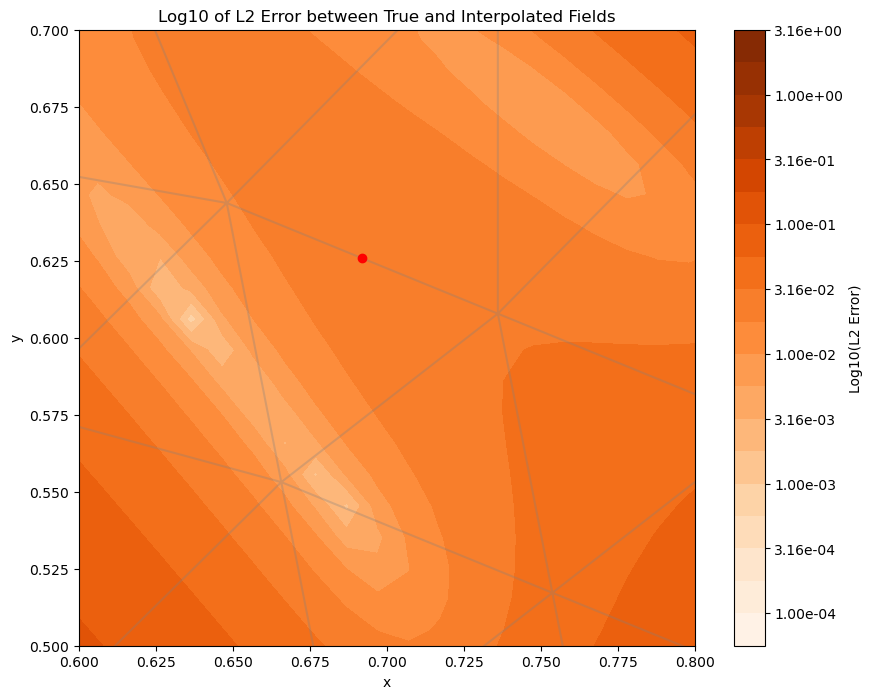

In [11]:
# Create the contour plot with log scale
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(X, Y, log_error_grid, levels=20, cmap='Oranges')
ax.plot(p[0], p[1], 'ro')
ax.set_title('Log10 of L2 Error between True and Interpolated Fields')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0.6,0.8)
ax.set_ylim(0.5,0.7)
ax.set_aspect('equal')
ax.triplot(vertices[:,0], vertices[:,1], triangles, alpha=0.3, color='gray')
cbar = fig.colorbar(contour, ax=ax, label='Log10(L2 Error)')

# Add custom tick labels to show actual error values
tick_locations = cbar.get_ticks()
tick_labels = [f'{10**x:.2e}' for x in tick_locations]
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

In [17]:
#form = lambda x: array([sin(pi*x[0])*cos(pi*x[1]), cos(pi*x[0])*sin(pi*x[1])])
form = lambda x,y: cos(pi*x)*cos(pi*y)
dform = lambda x: array([-pi*sin(pi*x[0])*cos(pi*x[1]), -pi*cos(pi*x[0])*sin(pi*x[1])])
hodge_form = lambda x: array([pi*cos(pi*x[0])*sin(pi*x[1]), -pi*sin(pi*x[0])*cos(pi*x[1])])

vertices = loadtxt('../pydec/Examples/DarcyFlow/vertices_tm0.5.txt')
triangles = loadtxt('../pydec/Examples/DarcyFlow/triangles_tm0.5.txt', dtype='int') - 1

sc = simplicial_complex((vertices,triangles))
N0 = sc[0].num_simplices
N1 = sc[1].num_simplices
w = sc.get_cochain(1)

hodge_error = []
num_loops = 4
max_volume_list = [max(sc[1].primal_volume)]
num_vertices_list = [len(vertices)]
num_triangles_list = [len(triangles)]
hodge = zeros(N1)
true_hodge = zeros(N1)

for j in range(num_loops):
    print('performing loop i = ', j, '     num_vertices = ', N0, '    mesh_size = ', max(sc[1].primal_volume))

    N0 = sc[0].num_simplices
    N1 = sc[1].num_simplices
    N2 = sc[2].num_simplices
    hodge = zeros(N1)
    true_hodge = zeros(N1)

    edges_to_triangles = create_edge_to_triangles(sc, triangles)

    w = sc.get_cochain(0)
    w[:] = form(vertices[:,0], vertices[:,1])
    grad_w = sc[0].d @ w[:]

    for i in range(N1):
        index = [set(sc[1].index_to_simplex[i]).issubset(t) for t in triangles]
        v0,v1 = vertices[sc[1].simplices[i]]
        parents = list(triangles[index])
        parents_index = list(sort([sc[2].simplex_to_index[simplex(t)] for t in parents]))
        edge_centroid = array(sc[1].circumcenter[i])
        rec_vec,_ = rec_vector_field_lsq(sc, grad_w, i, vertices, triangles, edges_to_triangles, verbose=False, hodge=True)
        
        if len(parents_index) == 2: #Arestas internas
            c = array([sc[2].circumcenter[j] for j in parents_index])
            aux = 0
            aux2 = 0
            for k, t in enumerate(parents_index):
                circ = c[k]
                sinal = np.sign(np.linalg.det([v1-v0, edge_centroid-circ]))
                aux2 += sinal * integral_edge(hodge_form, circ, edge_centroid)
                aux += sinal * integral_edge(rec_vec, circ, edge_centroid)
            
            true_hodge[i] = aux2
            hodge[i] = aux
            
        elif len(parents_index) == 1: #Arestas do bordo
            c = array([sc[2].circumcenter[j] for j in parents_index])
            c0 = c[0]
            sinal = np.sign(np.linalg.det([v1-v0, c0 - edge_centroid]))
            
            true_hodge[i] = sinal * integral_edge(hodge_form, edge_centroid, c0)
            hodge[i] = sinal * integral_edge(rec_vec, edge_centroid, c0)
    

    #new_u = max(abs(hodge - true_hodge))

    boundary_edges = sc.boundary()
    boundary_index = list(sort([sc[1].simplex_to_index[e] for e in boundary_edges]))
    num_boundary_edges = len(boundary_index)
    internal_edges = set(sc[1].simplex_to_index.keys()) - set(boundary_edges)
    internal_index = list(sort([sc[1].simplex_to_index[e] for e in internal_edges]))

    #Computing error in L2 norm
    new_u = norm(hodge[internal_index] - true_hodge[internal_index])
    print('Erro norma L2 = ', new_u)
    
    #aux_u = [u_sol(v[0], v[1]) for v in vertices]
    #print(norm(u-aux_u))
    
    #u_error.append(norm(u-aux_u))
    hodge_error.append(new_u)
    vertices, triangles = loop_subdivision(vertices, triangles)
    sc = simplicial_complex((vertices,triangles))
    max_volume_list.append(max(sc[1].primal_volume))
    num_vertices_list.append(len(vertices))
    num_triangles_list.append(len(triangles))

    N0 = len(vertices)
    print(order(hodge_error[:], max_volume_list[:-1]))
ordem = order(hodge_error[:], max_volume_list[:-1])

performing loop i =  0      num_vertices =  12     mesh_size =  0.5303300858899107
Erro norma L2 =  0.35558736117572703
[]
performing loop i =  1      num_vertices =  37     mesh_size =  0.26516504294495535
Erro norma L2 =  0.06875749835407276
[2.3706150861965063]
performing loop i =  2      num_vertices =  129     mesh_size =  0.1325825214724777
Erro norma L2 =  0.00972558405426872
[2.3706150861965063, 2.8216602587812503]
performing loop i =  3      num_vertices =  481     mesh_size =  0.06629126073623887
Erro norma L2 =  0.0012764063356341697
[2.3706150861965063, 2.8216602587812503, 2.9296972166441506]


In [14]:
ordem

[1.3706150861965063, 1.8216602587812503, 1.929697216644151]

It seems that the new hodge is consistent of order 2. With this result, we can use the new hodge to compute the laplacian of a 0-form. We hope to get a laplace operator of order 1.

In [87]:
#u = lambda x,y: np.cos(pi*x)*np.cos(pi*y)
#lap_u = lambda x,y: -2*pi**2*np.cos(pi*x)*np.cos(pi*y)

#u = lambda x,y: np.sin(x*y)
#lap_u = lambda x,y: -(x**2 + y**2)*np.sin(x*y)

u = lambda x,y: np.sin(y)*x**2
lap_u = lambda x,y: 2*np.sin(y) - np.sin(y)*x**2

#u = lambda x,y: x + y
#lap_u = lambda x,y:  0.0*(x/x)

vertices = loadtxt('../pydec/Examples/DarcyFlow/vertices_tm0.5.txt')
triangles = loadtxt('../pydec/Examples/DarcyFlow/triangles_tm0.5.txt', dtype='int') - 1
sc = simplicial_complex((vertices,triangles))
N0 = sc[0].num_simplices

lap_error = []
num_loops = 3
max_volume_list = [max(sc[1].primal_volume)]
num_vertices_list = [len(vertices)]
num_triangles_list = [len(triangles)]

for j in range(num_loops):
    print('performing loop i = ', j, '     num_vertices = ', N0,)
    cochain = u(vertices[:,0], vertices[:,1])
    true_lap = lap_u(vertices[:,0], vertices[:,1])

    edges_to_triangles = create_edge_to_triangles(sc, triangles)
    approx_lap = laplacian_lsq(sc, cochain, vertices, triangles, edges_to_triangles)

    x_points = set([(e[0]) for e in sc.boundary()])
    y_points = set([(e[1]) for e in sc.boundary()])
    boundary_points_index = sort(list(x_points.union(y_points)))
    boundary_points = vertices[boundary_points_index]
    num_boundary_points = len(boundary_points_index)

    internal_points = set(sc[0].simplex_to_index) - set([sc[0].index_to_simplex[e] for e in boundary_points_index])
    internal_index = sort(list(sc[0].simplex_to_index[p] for p in internal_points))
    #Computing error in L2 norm
    new_u = norm((approx_lap[internal_index] - true_lap[internal_index])*sc[0].dual_volume[internal_index]**(1/2))
    print('Erro norma L2 = ', new_u)
    #Computing error in L-inf norm
    #new_u = max(abs(approx_lap[internal_index] - true_lap[internal_index]))
    #print('Erro norma inf = ', new_u)
    
    lap_error.append(new_u)
    vertices, triangles = loop_subdivision(vertices, triangles)
    sc = simplicial_complex((vertices,triangles))
    max_volume_list.append(max(sc[1].primal_volume))
    num_vertices_list.append(len(vertices))
    num_triangles_list.append(len(triangles))

    N0 = len(vertices)
    print('lap_error =',lap_error)
    print('volume list =', max_volume_list)
    print('order =',order(lap_error[:], max_volume_list[:-1]))
ordem = order(lap_error, max_volume_list[:-1])

performing loop i =  0      num_vertices =  12
4
Erro norma L2 =  0.08125399391932144
lap_error = [0.08125399391932144]
volume list = [0.5303300858899107, 0.26516504294495535]
order = []
performing loop i =  1      num_vertices =  37
21
Erro norma L2 =  0.06097721930027267
lap_error = [0.08125399391932144, 0.06097721930027267]
volume list = [0.5303300858899107, 0.26516504294495535, 0.1325825214724777]
order = [0.4141683666257695]
performing loop i =  2      num_vertices =  129
97
Erro norma L2 =  0.027024535711067454
lap_error = [0.08125399391932144, 0.06097721930027267, 0.027024535711067454]
volume list = [0.5303300858899107, 0.26516504294495535, 0.1325825214724777, 0.06629126073623887]
order = [0.4141683666257695, 1.1740005293998403]


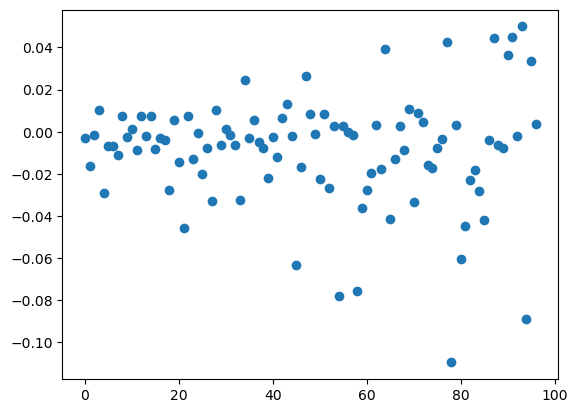

In [86]:
plt.scatter(np.arange(len(approx_lap[internal_index])),approx_lap[internal_index] - true_lap[internal_index])

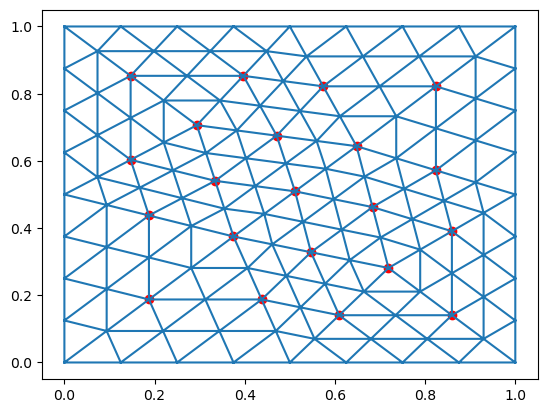

In [83]:
a = vertices[internal_index]
plt.scatter(a[:,0], a[:,1], color='red')
plt.triplot(vertices[:,0], vertices[:,1], triangles)

In [68]:
a = array([1,2,3])
a[:-1]

array([1, 2])

array([0.00042725, 0.00030136, 0.00040522, ..., 0.00089111, 0.00146484,
       0.0009196 ])